In [1]:
import rasterio
from rasterio.plot import show
from rasterio import features

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

import richdem as rd
from scipy import ndimage
from shapely.geometry import box
from rasterstats import zonal_stats

* My topic is finding a suitable ZCTAs for your father after his retirement.

* use MPO_boundaries to clip ZCTAs

In [2]:
MPO_Boundaries = gpd.read_file('data\MPO_Boundaries\MPO_Boundaries.shp')

In [3]:
zip_code = gpd.read_file('data'r'\tl_2010_25_zcta510'r'\tl_2010_25_zcta510.shp')

In [4]:
MPO_Boundaries = MPO_Boundaries.to_crs('EPSG:4269')

In [5]:
zip_clipped = gpd.clip(zip_code,MPO_Boundaries)

In [6]:
zip_clipped.head()

,STATEFP10,ZCTA5CE10,GEOID10,CLASSFP10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,PARTFLG10,geometry
0,25,02536,2502536,B5,G6350,S,71696166,9066635,+41.5969756,-070.5678768,N,"MULTIPOLYGON (((-70.59268 41.55997, -70.59284 ..."
1,25,02556,2502556,B5,G6350,S,10034104,1164445,+41.6394454,-070.6245149,N,"MULTIPOLYGON (((-70.62633 41.61704, -70.62781 ..."
2,25,02540,2502540,B5,G6350,S,27746696,4550024,+41.5741900,-070.6282848,N,"MULTIPOLYGON (((-70.62262 41.61655, -70.62263 ..."
3,25,02646,2502646,B5,G6350,S,7798581,801405,+41.6705961,-070.0714493,N,"MULTIPOLYGON (((-70.07864 41.67791, -70.07855 ..."
4,25,01237,2501237,B5,G6350,S,160121626,1140685,+42.5478177,-073.2680327,N,"POLYGON ((-73.23587 42.49338, -73.23625 42.493..."


* First indicater is the percentage of people who are 60 and over 60,
* Staying with too many olp people can help my father make friends

In [7]:
age_and_sex = gpd.read_file('data'r'\age_and_sex\ACSST5Y2019.S0101_data_with_overlays.csv')

C:\Users\surface\Anaconda3\envs\uep239hw7\lib\site-packages\geopandas\geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


* Visulize the data

In [8]:
age_and_sex.head()

,GEO_ID,NAME,S0101_C01_001E,S0101_C01_001M,S0101_C01_002E,S0101_C01_002M,S0101_C01_003E,S0101_C01_003M,S0101_C01_004E,S0101_C01_004M,...,S0101_C06_034M,S0101_C06_035E,S0101_C06_035M,S0101_C06_036E,S0101_C06_036M,S0101_C06_037E,S0101_C06_037M,S0101_C06_038E,S0101_C06_038M,geometry
0,id,Geographic Area Name,Estimate!!Total!!Total population,Margin of Error!!Total!!Total population,Estimate!!Total!!Total population!!AGE!!Under ...,Margin of Error!!Total!!Total population!!AGE!...,Estimate!!Total!!Total population!!AGE!!5 to 9...,Margin of Error!!Total!!Total population!!AGE!...,Estimate!!Total!!Total population!!AGE!!10 to ...,Margin of Error!!Total!!Total population!!AGE!...,...,Margin of Error!!Percent Female!!Total populat...,Estimate!!Percent Female!!Total population!!SU...,Margin of Error!!Percent Female!!Total populat...,Estimate!!Percent Female!!Total population!!SU...,Margin of Error!!Percent Female!!Total populat...,Estimate!!Percent Female!!Total population!!PE...,Margin of Error!!Percent Female!!Total populat...,Estimate!!Percent Female!!Total population!!PE...,Margin of Error!!Percent Female!!Total populat...,None
1,8600000US01001,ZCTA5 01001,17312,735,956,233,863,222,967,274,...,(X),(X),(X),(X),(X),(X),(X),(X),(X),None
2,8600000US01002,ZCTA5 01002,30014,485,872,143,1043,192,1123,215,...,(X),(X),(X),(X),(X),(X),(X),(X),(X),None
3,8600000US01003,ZCTA5 01003,11357,477,0,19,0,19,0,19,...,(X),(X),(X),(X),(X),(X),(X),(X),(X),None
4,8600000US01005,ZCTA5 01005,5128,404,127,72,199,139,408,153,...,(X),(X),(X),(X),(X),(X),(X),(X),(X),None


* data preprocess

In [9]:
age_and_sex = age_and_sex.drop([0])

In [10]:
age_and_sex['NAME'] = age_and_sex['NAME'].map(lambda x:x.lstrip('ZCTA5'))

In [11]:
age = age_and_sex[['NAME','S0101_C02_028E']]

In [12]:
zip_clipped['ZCTA5CE10'] = zip_clipped['ZCTA5CE10'].apply(pd.to_numeric,errors = 'coerce')

In [13]:
age['NAME'] = age['NAME'].apply(pd.to_numeric,errors = 'coerce')

<ipython-input-13-e1d3a8c93ca9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age['NAME'] = age['NAME'].apply(pd.to_numeric,errors = 'coerce')


In [14]:
zip_age = pd.merge(zip_clipped,age,how = 'left',left_on = 'ZCTA5CE10',right_on = 'NAME')

In [15]:
zip_age = zip_age.drop('NAME',axis = 1)

In [16]:
ZCTA = []
for i in range(0,538):
    k = '%05d'%zip_age['ZCTA5CE10'][i]
    ZCTA.append(k)
zip_age['ZCTA5CE10'] = ZCTA

* for each ZCTA to show certain percentage

In [17]:
zip_age = zip_age[['ZCTA5CE10','geometry','S0101_C02_028E']]
zip_age.head()

,ZCTA5CE10,geometry,S0101_C02_028E
0,02536,"MULTIPOLYGON (((-70.59268 41.55997, -70.59284 ...",35.8
1,02556,"MULTIPOLYGON (((-70.62633 41.61704, -70.62781 ...",51.3
2,02540,"MULTIPOLYGON (((-70.62262 41.61655, -70.62263 ...",50.6
3,02646,"MULTIPOLYGON (((-70.07864 41.67791, -70.07855 ...",54.2
4,01237,"POLYGON ((-73.23587 42.49338, -73.23625 42.493...",35.4


In [18]:
zip_age.sort_values('S0101_C02_028E',ascending=False)
zip_age['S0101_C02_028E'] = zip_age['S0101_C02_028E'].apply(pd.to_numeric,errors = 'coerce')

In [19]:
zip_age.isna().sum()

ZCTA5CE10         0
geometry          0
S0101_C02_028E    4
dtype: int64

In [20]:
zip_age.sort_values('S0101_C02_028E',ascending=False)

,ZCTA5CE10,geometry,S0101_C02_028E
66,02663,"MULTIPOLYGON (((-69.97726 41.92085, -69.97738 ...",100.0
225,01066,"POLYGON ((-72.64472 42.41251, -72.63481 42.413...",100.0
471,02203,"POLYGON ((-71.05781 42.35892, -71.05815 42.359...",100.0
481,02553,"MULTIPOLYGON (((-70.60907 41.71583, -70.60915 ...",100.0
207,01229,"MULTIPOLYGON (((-73.34991 42.28025, -73.34950 ...",80.2
...,...,...,...
356,01086,"POLYGON ((-72.79660 42.13150, -72.79560 42.131...",0.0
146,02861,"POLYGON ((-71.35520 41.89723, -71.35506 41.896...",NaN
379,02584,"POLYGON ((-70.01045 41.25884, -70.01071 41.259...",NaN
485,02643,"MULTIPOLYGON (((-69.93146 41.72671, -69.93159 ...",NaN


In [21]:
zip_age.dropna(inplace = True)

* choropleth map for values

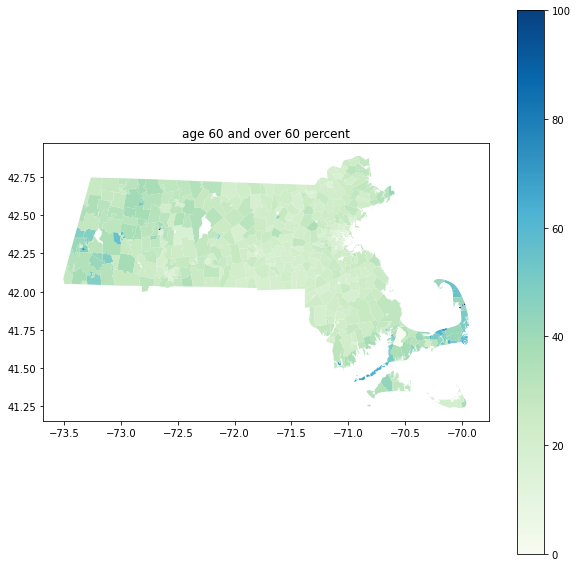

In [22]:
fig,ax = plt.subplots(1, 1, figsize=(10, 10))

zip_age.plot(column = 'S0101_C02_028E',legend=True,ax=ax,cmap = 'GnBu')

ax.set_title("age 60 and over 60 percent")

plt.show()

In [23]:
zip_age.sort_values('S0101_C02_028E',ascending=False)

,ZCTA5CE10,geometry,S0101_C02_028E
66,02663,"MULTIPOLYGON (((-69.97726 41.92085, -69.97738 ...",100.0
225,01066,"POLYGON ((-72.64472 42.41251, -72.63481 42.413...",100.0
471,02203,"POLYGON ((-71.05781 42.35892, -71.05815 42.359...",100.0
481,02553,"MULTIPOLYGON (((-70.60907 41.71583, -70.60915 ...",100.0
207,01229,"MULTIPOLYGON (((-73.34991 42.28025, -73.34950 ...",80.2
...,...,...,...
198,02542,"POLYGON ((-70.57049 41.75556, -70.56659 41.753...",0.0
508,01063,"MULTIPOLYGON (((-72.63635 42.31798, -72.63600 ...",0.0
344,01937,"POLYGON ((-70.97970 42.58551, -70.97953 42.585...",0.0
114,02457,"POLYGON ((-71.26480 42.29674, -71.26476 42.296...",0.0


* Calculate the score:
* The percentage of people who are 60 and over 60 is higher,the score is higher

In [24]:
a = zip_age.quantile([.2,.4,.6,.8],numeric_only = True)

In [25]:
print(a)

     S0101_C02_028E
0.2           19.56
0.4           22.70
0.6           26.50
0.8           31.88


In [26]:
conditions = [
    (zip_age['S0101_C02_028E'] <= 19.56),
    (zip_age['S0101_C02_028E'] > 19.56) & (zip_age['S0101_C02_028E'] <= 22.70),
    (zip_age['S0101_C02_028E'] > 22.70) & (zip_age['S0101_C02_028E'] <= 26.50),
    (zip_age['S0101_C02_028E'] > 26.50) & (zip_age['S0101_C02_028E'] <= 31.88),
    (zip_age['S0101_C02_028E'] > 31.88)
    ]
values = [1,2,3,4,5]
zip_age['score'] = np.select(conditions,values)


In [27]:
age_highest = zip_age[(zip_age['score'])==5]

In [28]:
age_lowest = zip_age[(zip_age['score'])==1]

* highest,lowest rank ZCTAs

In [29]:
age_highest['ZCTA5CE10']

0      02536
1      02556
2      02540
3      02646
4      01237
       ...  
495    02713
498    01355
499    01340
509    01012
534    01503
Name: ZCTA5CE10, Length: 107, dtype: object

In [30]:
age_lowest['ZCTA5CE10']

16     01841
17     01905
32     01105
33     01104
34     01097
       ...  
523    02071
526    02129
527    02128
528    02122
530    01605
Name: ZCTA5CE10, Length: 107, dtype: object

* choropleth map for scores

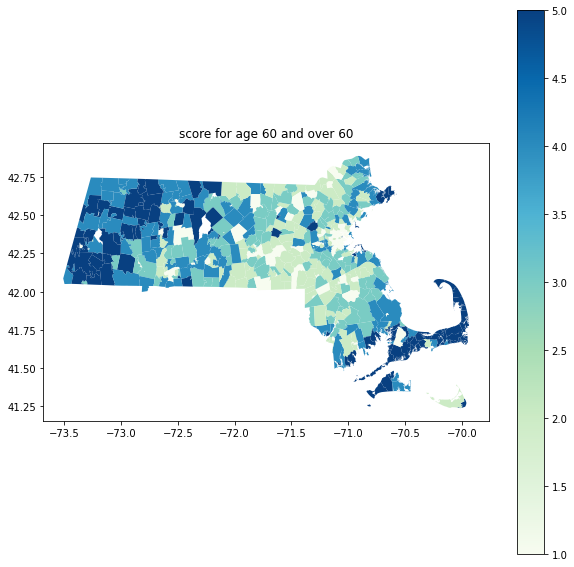

In [31]:
fig,ax = plt.subplots(1, 1, figsize=(10, 10))
zip_age.plot(column = 'score',legend=True,ax=ax,cmap = 'GnBu')
ax.set_title("score for age 60 and over 60")
plt.show()

* The second indicater is about communities' locations

In [32]:
community = gpd.read_file('data\community_health_center\CHCS_PT.shp')

In [33]:
community = community.to_crs("EPSG:2249")

* in order to calculate the density so the crs should be suitable for area's crs

In [34]:
community.head()

,SITE_NAME,SITE_TYPE,ADMIN_ONLY,ADDRESS,ADDRESS_OT,MAIL_CITY,ZIP,PO_BOX,TOWN,TOWN_ID,SATELLITE,EYE,DENTAL,METHOD,GIS_ID,MCHC_CODE,MAD_ID,geometry
0,South Site Clinic,NOS,N,73D Winthrop Avenue,Plaza 114,Lawrence,01843,None,LAWRENCE,149,Y,N,N,G,S98,GLFHC,2123658,POINT (750123.742 3076480.162)
1,Chinatown Clinic,NOS,N,885 Washington Street,None,Boston,02111,None,BOSTON,35,Y,N,N,G,S99,SCCHC,35145770,POINT (773778.949 2952132.264)
2,Great Barrington Family Dental,NOS,N,"343 Main Street, Rear",None,Great Barrington,01230,None,GREAT BARRINGTON,113,Y,N,Y,G,S100,CHP,211384,POINT (151417.127 2900871.205)
3,St. Francis House Clinic,HOMELESS,N,39 Boylston Street,None,Boston,02116,None,BOSTON,35,Y,N,N,G,S101,BHCHP,35018316,POINT (774130.067 2953777.630)
4,St. Vincent's School,SCHOOL,N,2425 Highland Avenue,None,Fall River,02720,None,FALL RIVER,95,Y,N,N,G,S102,SBJHC,3944034,POINT (758174.914 2728453.542)


In [35]:
zip_clipped = zip_clipped.to_crs("EPSG:2249")

In [36]:
zip_clipped['area'] = zip_clipped.area

In [37]:
community['ZIP'] = community['ZIP'].apply(pd.to_numeric,errors = 'coerce')

In [38]:
community_count = community['TOWN_ID'].groupby(community['ZIP']).agg(['count'])

In [39]:
zip_community = pd.merge(zip_clipped,community_count,left_on = 'ZCTA5CE10',right_index = True,how = 'left')

In [40]:
ZCTA = []
for i in range(0,538):
    k = '%05d'%zip_community['ZCTA5CE10'][i]
    ZCTA.append(k)
zip_community['ZCTA5CE10'] = ZCTA
zip_community.head()

,STATEFP10,ZCTA5CE10,GEOID10,CLASSFP10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,PARTFLG10,geometry,area,count
0,25,02536,2502536,B5,G6350,S,71696166,9066635,+41.5969756,-070.5678768,N,"MULTIPOLYGON (((904487.410 2666001.182, 904443...",7.919714e+08,NaN
1,25,02556,2502556,B5,G6350,S,10034104,1164445,+41.6394454,-070.6245149,N,"MULTIPOLYGON (((895064.396 2686697.377, 894658...",1.114540e+08,NaN
2,25,02540,2502540,B5,G6350,S,27746696,4550024,+41.5741900,-070.6282848,N,"MULTIPOLYGON (((896081.749 2686530.715, 896078...",3.164889e+08,1.0
3,25,02646,2502646,B5,G6350,S,7798581,801405,+41.6705961,-070.0714493,N,"MULTIPOLYGON (((1044446.862 2710891.593, 10444...",8.502199e+07,NaN
4,25,01237,2501237,B5,G6350,S,160121626,1140685,+42.5478177,-073.2680327,N,"POLYGON ((188027.382 3009582.788, 187927.489 3...",1.734928e+09,NaN


In [41]:
zip_community.dropna(inplace = True)

In [42]:
zip_community['density'] = zip_community['count']/zip_community['area']

* choropleth map for community's density

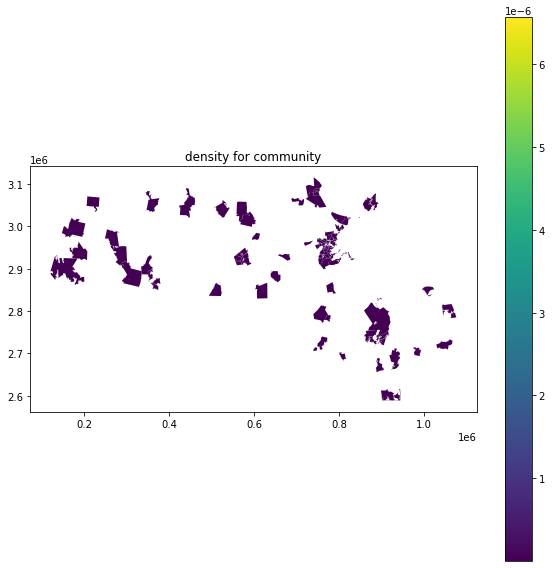

In [43]:
fig,ax = plt.subplots(1, 1, figsize=(10, 10))
zip_community.plot(column = 'density',legend=True,ax=ax)
ax.set_title("density for community")
plt.show()

In [44]:
a = zip_community.quantile([.2,.4,.6,.8],numeric_only = True)
print(a)

        ALAND10   AWATER10          area  count       density
0.2   4001513.2   191927.4  4.362014e+07    1.0  2.412323e-09
0.4   8508487.0   485127.0  9.497884e+07    1.0  7.533476e-09
0.6  15224048.2  1464101.2  1.772634e+08    2.0  2.099101e-08
0.8  56572768.2  3511950.6  6.386467e+08    3.0  4.972102e-08


In [45]:
conditions = [
    (zip_community['density'] <= 2.412323e-09),
    (zip_community['density'] > 2.412323e-09) & (zip_community['density'] <= 7.533476e-09),
    (zip_community['density'] > 7.533476e-09) & (zip_community['density'] <= 2.099101e-08),
    (zip_community['density'] > 2.099101e-08) & (zip_community['density'] <= 4.972102e-08),
    (zip_community['density'] > 4.972102e-08)
    ]
values = [1,2,3,4,5]
zip_community['score'] = np.select(conditions,values)


* choropleth map for community's score which is calculated by community's density

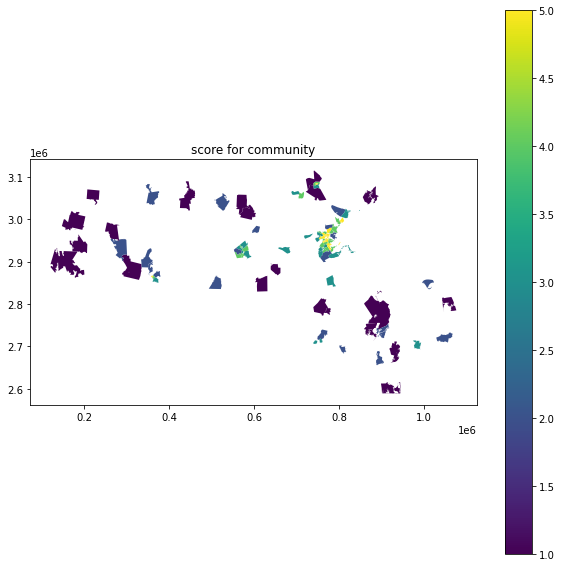

In [46]:
fig,ax = plt.subplots(1, 1, figsize=(10, 10))

zip_community.plot(column = 'score',legend=True,ax=ax)

ax.set_title("score for community")

plt.show()

* highest,lowest rank ZCTAs

In [47]:
community_highest = zip_community[(zip_community['score'])==5]

In [48]:
community_lowest = zip_community[(zip_community['score'])==1]

In [49]:
community_highest['ZCTA5CE10']

50     02134
51     02125
53     02118
107    02149
149    01840
150    01901
182    02113
186    02115
318    02114
368    02141
371    02139
391    02111
428    01902
467    02116
470    02120
503    01103
506    01199
510    02143
526    02129
528    02122
Name: ZCTA5CE10, dtype: object

In [50]:
community_lowest['ZCTA5CE10']

20     01930
58     01569
82     01810
142    02780
147    02539
156    01085
179    02360
194    01420
204    01238
261    02667
266    01220
277    01844
282    01364
288    01098
333    02649
386    02571
402    01453
478    01757
486    01230
487    01201
Name: ZCTA5CE10, dtype: object

* third indicater is about the hospital's location

In [51]:
hospital = gpd.read_file('data\care_hospital\HOSPITALS_PT.shp')
hospital = hospital.to_crs("EPSG:2249")

In [52]:
hospital.head()

,IDNUMBER,DPHID,NAME,SHORTNAME,ADDRESS,TOWN,GEOG_TOWN,ZIPCODE,CHIAREGION,TELEPHONE,...,TAXSTATUS,BEDCOUNT,ER_STATUS,TRAUMA_ADU,TRAUMA_PED,SPEPUBFUND,FYE,MADID,EMSREGION,geometry
0,2069,2069,Beth Israel Deaconess Medical Center East,BIDMC East,330 Brookline Avenue,Boston,BOSTON,02215,Metro Boston,(617) 667-7000,...,Non-profit,248,N,None,None,Not Applicable,2017-09-30,35022096,4,POINT (762774.364 2949108.676)
1,2085,2085,Steward St. Elizabeth's Medical Center,St. Elizabeth's Medical Center,736 Cambridge Street,Brighton,BOSTON,02135,Metro Boston,(617) 789-3000,...,For profit,252,Y,None,None,Not Applicable,2017-12-31,35156980,4,POINT (751323.820 2952613.158)
2,2299,2299,Tufts Medical Center,Tufts Medical Center,800 Washington Street,Boston,BOSTON,02111,Metro Boston,(617) 636-5000,...,Non-profit,415,Y,Level 1,Level 1,Not Applicable,2017-09-30,35145764,4,POINT (774155.632 2952743.926)
3,2103,2103,UMass Memorial Marlborough Hospital,Marlborough Hospital,157 Union Street,Marlborough,MARLBOROUGH,01752,Metro West,(508) 481-5000,...,Non-profit,79,Y,None,None,CHART,2017-09-30,1613538,4,POINT (641372.652 2954506.563)
4,2167,2167,Massachusetts Eye and Ear Infirmary,Massachusetts Eye and Ear Infirmary,243 Charles Street,Boston,BOSTON,02114,Metro Boston,(617) 523-7900,...,Non-profit,41,Y,None,None,Not Applicable,2017-09-30,35163139,4,POINT (772297.057 2957516.740)


In [53]:
hospital['ZIPCODE'] = hospital['ZIPCODE'].apply(pd.to_numeric,errors = 'coerce')
hospital_count = hospital['IDNUMBER'].groupby(hospital['ZIPCODE']).agg(['count'])

In [54]:
zip_hospital = pd.merge(zip_clipped,hospital_count,left_on = 'ZCTA5CE10',right_index = True,how = 'left')

In [55]:
ZCTA = []
for i in range(0,538):
    k = '%05d'%zip_hospital['ZCTA5CE10'][i]
    ZCTA.append(k)
zip_hospital['ZCTA5CE10'] = ZCTA

In [56]:
zip_hospital.dropna(inplace = True)
zip_hospital['density'] = zip_hospital['count']/zip_hospital['area']

* choropleth map for hospital's density

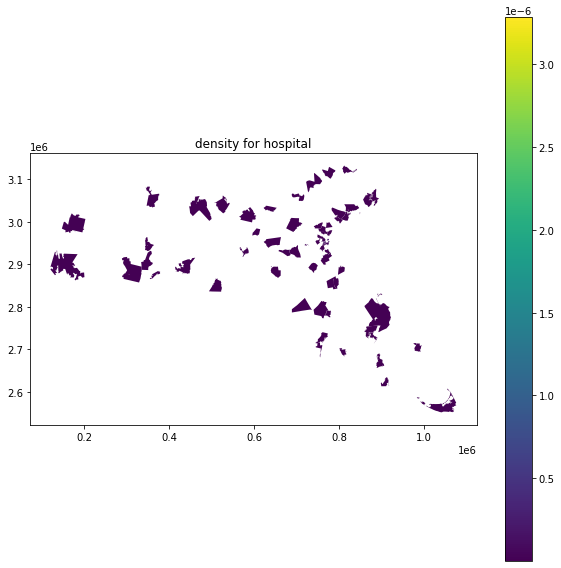

In [57]:
fig,ax = plt.subplots(1, 1, figsize=(10, 10))

zip_hospital.plot(column = 'density',legend=True,ax=ax)

ax.set_title("density for hospital")

plt.show()

In [58]:
a = zip_hospital.quantile([.2,.4,.6,.8],numeric_only = True)
print(a)

        ALAND10   AWATER10          area  count       density
0.2   8292142.2   318466.8  9.159540e+07    1.0  1.418145e-09
0.4  18481486.2   914814.6  2.055464e+08    1.0  2.865933e-09
0.6  31419178.0  2145250.2  3.489930e+08    1.0  4.866736e-09
0.8  62679737.0  4086787.4  7.052915e+08    1.0  1.180523e-08


In [59]:
conditions = [
    (zip_hospital['density'] <= 1.418145e-09),
    (zip_hospital['density'] > 1.418145e-09) & (zip_hospital['density'] <= 2.865933e-09),
    (zip_hospital['density'] > 2.865933e-09) & (zip_hospital['density'] <= 4.866736e-09),
    (zip_hospital['density'] > 4.866736e-09) & (zip_hospital['density'] <= 1.180523e-08),
    (zip_hospital['density'] > 1.180523e-08)
    ]
values = [1,2,3,4,5]
zip_hospital['score'] = np.select(conditions,values)


* choropleth map for hospital's score

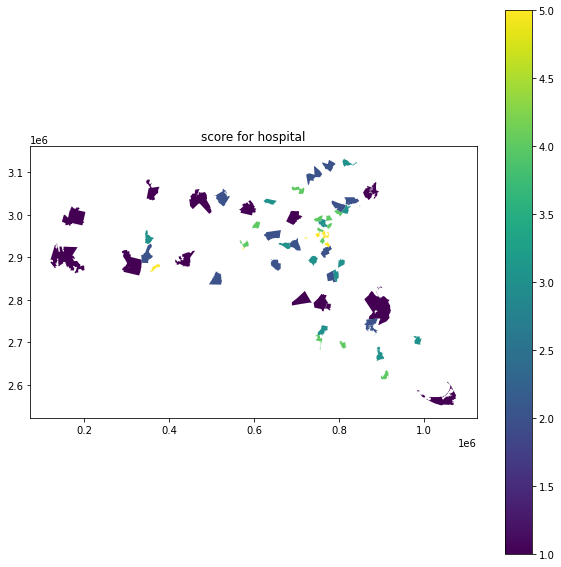

In [60]:
fig,ax = plt.subplots(1, 1, figsize=(10, 10))

zip_hospital.plot(column = 'score',legend=True,ax=ax)

ax.set_title("score for hospital")

plt.show()

* highest,lowest rank ZCTAs

In [61]:
hospital_highest = zip_hospital[(zip_hospital['score'])==5]
hospital_lowest = zip_hospital[(zip_hospital['score'])==1]

In [62]:
print(hospital_highest['ZCTA5CE10'])

33     01104
35     02462
53     02118
186    02115
245    02135
316    02124
318    02114
371    02139
391    02111
397    01608
470    02120
506    01199
522    02215
Name: ZCTA5CE10, dtype: object


In [63]:
print(hospital_lowest['ZCTA5CE10'])

20     01930
25     01301
63     01331
142    02780
156    01085
179    02360
229    01742
267    02703
302    02554
402    01453
486    01230
487    01201
502    01069
Name: ZCTA5CE10, dtype: object


* the fourth indicater is about the location of farmer market

In [64]:
FarmerMarket = gpd.read_file('data'r'\farmers_market\FARMERSMARKETS_PT.shp')
FarmerMarket = FarmerMarket.to_crs("EPSG:2249")

In [65]:
FarmerMarket.head()

,MARKET_ID,NAME,TYPE,ADDR_1,ADDR_2,TOWN,ZIP_CODE,DAY_TIME,DATES,UPDATE_DAT,YEAR_START,WEBSITE,EBT,WIC_CVV,COUPONS,LONGITUDE,LATITUDE,geometry
0,606.0,Sustainable Nantucket/Wednesday,Farmers Markets,113 Pleasant St.,Next to Glidden's Seafood,Nantucket,02554,"Wednesday, 3:30 pm - 6:30 pm",July 6 to September 14,2016,2016,http://www.sustainablenantucket.org,EBT-SNAP Accepted,None,WIC & Senior Coupons Accepted,-70.09361,41.27301,POINT (1042790.186 2563299.411)
1,607.0,Holden/Market on Main at Jed's,Farmers Markets,450 Main St.,Jed's Hardware and Garden,Holden,01520,"Friday, 3:30 pm - 7:00 pm",May 20 to October 28,2016,2016,None,None,None,None,-71.83454,42.33213,POINT (565709.759 2946234.079)
2,535.0,West Newton,Farmers Markets,Elm Street,off Washington Street,West Newton,02465,"Saturday, 10:00 am - 2:00 pm",June 18 to October 8,2016,2014,http://www.newtonma.gov/gov/parks,EBT-SNAP Accepted,None,WIC & Senior Coupons Accepted,-71.22932,42.34906,POINT (729336.834 2952342.466)
3,538.0,Plainville,Farmers Markets,200 South Street,Old Wood School,Plainville,02762,"Sunday, 10:00 am - 2:00 pm",May 25 to November 2,2015,2014,http://www.plainvillefarmersmarket.com/,EBT-SNAP Accepted,None,WIC & Senior Coupons Accepted,-71.33843,42.00941,POINT (700076.740 2828495.420)
4,539.0,Worcester Art Museum,Farmers Markets,Lancaster St.,Worcester Art Museum,Worcester,01609,"Saturdays, 10:00 am - 1:00 pm",July 11 to August 29,2015,2014,None,None,None,WIC & Senior Coupons Accepted,-71.80202,42.27328,POINT (574426.928 2924755.290)


In [66]:
FarmerMarket['ZIP_CODE'] = FarmerMarket['ZIP_CODE'].apply(pd.to_numeric,errors = 'coerce')
FarmerMarket_count = FarmerMarket['MARKET_ID'].groupby(FarmerMarket['ZIP_CODE']).agg(['count'])

In [67]:
zip_FarmerMarket = pd.merge(zip_clipped,FarmerMarket_count,left_on = 'ZCTA5CE10',right_index = True,how = 'left')

In [68]:
ZCTA = []
for i in range(0,538):
    k = '%05d'%zip_FarmerMarket['ZCTA5CE10'][i]
    ZCTA.append(k)
zip_FarmerMarket['ZCTA5CE10'] = ZCTA

In [69]:
zip_FarmerMarket.dropna(inplace = True)
zip_FarmerMarket['density'] = zip_FarmerMarket['count']/zip_FarmerMarket['area']

* choropleth map for farmermarket's density

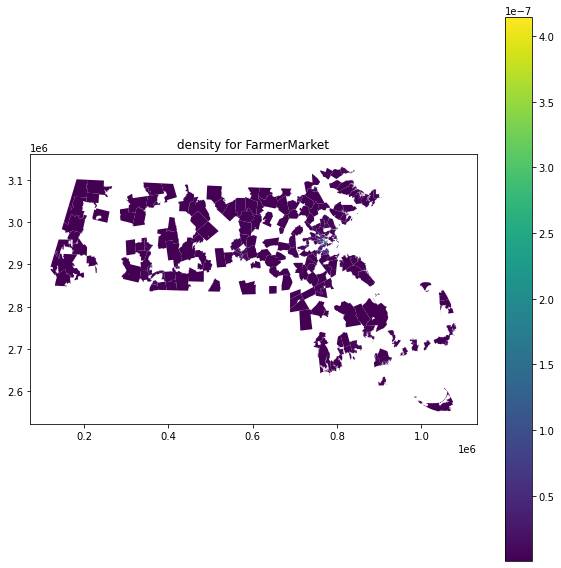

In [70]:
fig,ax = plt.subplots(1, 1, figsize=(10, 10))

zip_FarmerMarket.plot(column = 'density',legend=True,ax=ax)

ax.set_title("density for FarmerMarket")

plt.show()

In [71]:
a = zip_FarmerMarket.quantile([.2,.4,.6,.8],numeric_only = True)
print(a)

        ALAND10   AWATER10          area  count       density
0.2   9903144.0   340172.4  1.117195e+08    1.0  1.505471e-09
0.4  28191474.4   931765.8  3.168017e+08    1.0  2.444985e-09
0.6  43868397.0  1803280.0  4.929142e+08    1.0  4.093594e-09
0.8  69897654.8  3597129.2  7.803455e+08    2.0  1.078422e-08


In [72]:
conditions = [
    (zip_FarmerMarket['density'] <= 1.505471e-09),
    (zip_FarmerMarket['density'] > 1.505471e-09) & (zip_FarmerMarket['density'] <= 2.444985e-09),
    (zip_FarmerMarket['density'] > 2.444985e-09) & (zip_FarmerMarket['density'] <= 4.093594e-09),
    (zip_FarmerMarket['density'] > 4.093594e-09) & (zip_FarmerMarket['density'] <= 1.078422e-08),
    (zip_FarmerMarket['density'] > 1.078422e-08)
    ]
values = [1,2,3,4,5]
zip_FarmerMarket['score'] = np.select(conditions,values)


* choropleth map for farmermarket's score

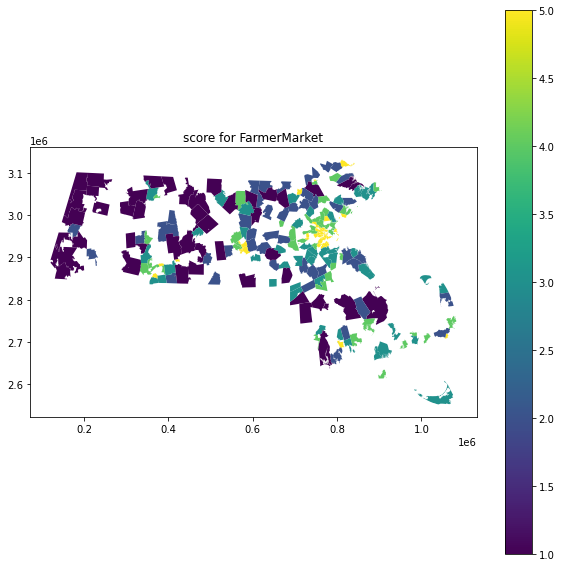

In [73]:
fig,ax = plt.subplots(1, 1, figsize=(10, 10))

zip_FarmerMarket.plot(column = 'score',legend=True,ax=ax)

ax.set_title("score for FarmerMarket")

plt.show()

* highest,lowest rank ZCTAs

In [74]:
FarmerMarket_highest = zip_FarmerMarket[(zip_FarmerMarket['score'])==5]
FarmerMarket_lowest = zip_FarmerMarket[(zip_FarmerMarket['score'])==1]
print(FarmerMarket_highest['ZCTA5CE10'])
print(FarmerMarket_lowest['ZCTA5CE10'])

50     02134
52     02110
53     02118
59     01610
88     01950
102    02465
116    02126
117    02152
118    02109
132    02659
149    01840
150    01901
155    01108
162    02468
165    02144
167    02176
183    02130
185    02119
217    01151
245    02135
286    01080
305    02446
316    02124
319    02108
339    02740
346    01907
361    01852
365    02145
367    02138
371    02139
375    02474
391    02111
397    01608
451    02142
467    02116
468    02131
469    02127
470    02120
472    01604
510    02143
522    02215
526    02129
528    02122
530    01605
Name: ZCTA5CE10, dtype: object
4      01237
9      01270
26     01337
29     01330
57     01005
63     01331
82     01810
98     01010
101    01082
142    02780
151    01938
156    01085
160    01027
179    02360
204    01238
208    02790
222    01007
242    02346
249    01516
250    01473
252    01366
266    01220
267    02703
282    01364
307    02038
349    01370
354    01057
374    01450
393    01475
405    01562
417    

* the fifth indicater is about the location of fire station

In [75]:
FireStation = gpd.read_file('data'r'\fire_station\FIRESTATIONS_PT_MEMA.shp')
FireStation = FireStation.to_crs("EPSG:2249")

In [76]:
FireStation.head()

,NAME,OFFICE,ADDRESS,CITY,STATE,ZIP,L_SRC,SOURCE,L_DATE,geometry
0,MILLBURY FIRE DEPARTMENT,Headquarters,127 Elm Street,MILLBURY,MA,01527,MEMA,MEMA,2006-08-16,POINT (584978.897 2894612.094)
1,MILLBURY FIRE DEPARTMENT,Station 5,240 Millbury Avenue,MILLBURY,MA,01527,MEMA,MEMA,2006-08-16,POINT (586936.176 2904185.828)
2,MILLIS FIRE DEPARTMENT,Headquarters,885 Main Street,MILLIS,MA,02054,MEMA,MEMA,2006-08-16,POINT (694465.226 2886041.508)
3,MILLVILLE FIRE DEPARTMENT,Headquarters,196 Main Street,MILLVILLE,MA,01529,MEMA,MEMA,2006-08-16,POINT (634533.260 2835094.595)
4,MILLVILLE FIRE DEPARTMENT,Station 2,268 Chestnut Hill Road,MILLVILLE,MA,01529,MEMA,MEMA,2006-08-16,POINT (634247.040 2840785.069)


In [77]:
FireStation['ZIP'] = FireStation['ZIP'].apply(pd.to_numeric,errors = 'coerce')
FireStation_count = FireStation['ADDRESS'].groupby(FireStation['ZIP']).agg(['count'])

In [78]:
zip_FireStation = pd.merge(zip_clipped,FireStation_count,left_on = 'ZCTA5CE10',right_index = True,how = 'left')

In [79]:
ZCTA = []
for i in range(0,538):
    k = '%05d'%zip_FireStation['ZCTA5CE10'][i]
    ZCTA.append(k)
zip_FireStation['ZCTA5CE10'] = ZCTA

In [80]:
zip_FireStation.dropna(inplace = True)
zip_FireStation['density'] = zip_FireStation['count']/zip_FireStation['area']

* choropleth map for firestationt's density

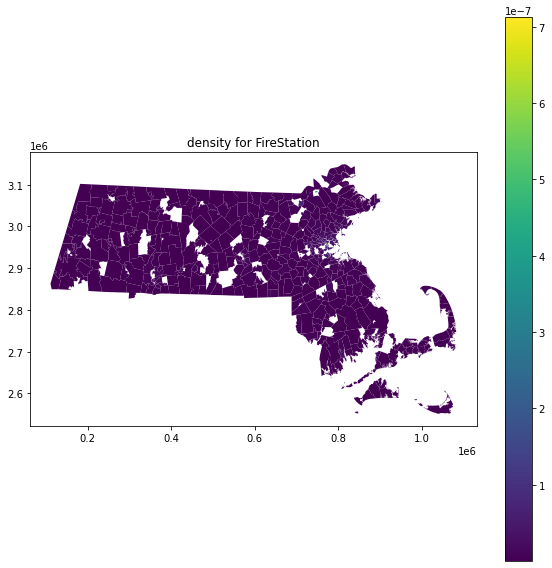

In [81]:
fig,ax = plt.subplots(1, 1, figsize=(10, 10))

zip_FireStation.plot(column = 'density',legend=True,ax=ax)

ax.set_title("density for FireStation")

plt.show()

In [82]:
a = zip_FireStation.quantile([.2,.4,.6,.8],numeric_only = True)
print(a)

        ALAND10   AWATER10          area  count       density
0.2  12677252.6   342320.2  1.405192e+08    1.0  1.822728e-09
0.4  29129303.2   988929.0  3.212927e+08    1.0  3.035911e-09
0.6  44211464.4  1900662.2  4.968406e+08    2.0  5.396308e-09
0.8  68170747.4  3590151.0  7.464157e+08    3.0  1.277796e-08


In [83]:
conditions = [
    (zip_FireStation['density'] <= 1.822728e-09),
    (zip_FireStation['density'] > 1.822728e-09) & (zip_FireStation['density'] <= 3.035911e-09),
    (zip_FireStation['density'] > 3.035911e-09) & (zip_FireStation['density'] <= 5.396308e-09),
    (zip_FireStation['density'] > 5.396308e-09) & (zip_FireStation['density'] <= 1.277796e-08),
    (zip_FireStation['density'] > 1.277796e-08)
    ]
values = [1,2,3,4,5]
zip_FireStation['score'] = np.select(conditions,values)

* choropleth map for firestationt's score

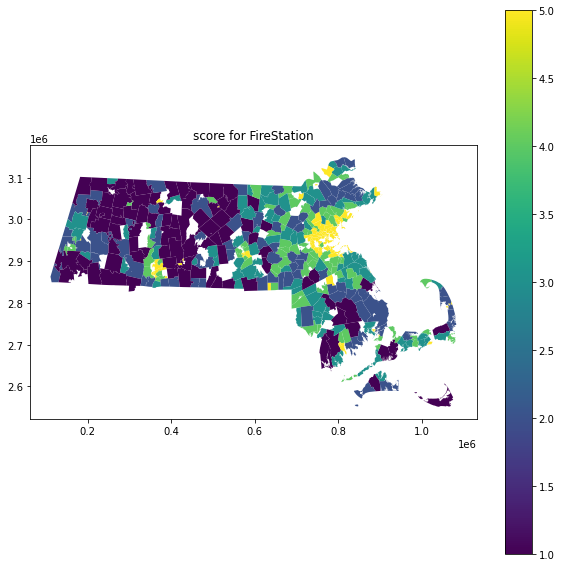

In [84]:
fig,ax = plt.subplots(1, 1, figsize=(10, 10))

zip_FireStation.plot(column = 'score',legend=True,ax=ax)

ax.set_title("score for FireStation")

plt.show()

* highest,lowest rank ZCTAs

In [85]:
FireStation_highest = zip_FireStation[(zip_FireStation['score'])==5]
FireStation_lowest = zip_FireStation[(zip_FireStation['score'])==1]
print(FireStation_highest['ZCTA5CE10'])
print(FireStation_lowest['ZCTA5CE10'])

6      01242
17     01905
18     01904
32     01105
33     01104
       ...  
512    02472
526    02129
527    02128
528    02122
529    02151
Name: ZCTA5CE10, Length: 83, dtype: object
0      02536
9      01270
11     01256
25     01301
28     01339
       ...  
504    01034
507    01096
535    01452
536    01571
537    01468
Name: ZCTA5CE10, Length: 83, dtype: object


* sixth indicater is preprocessed raster data which is about Percentage (%) of pixel area covered by tree canopy (0-100)

In [86]:
tree = rasterio.open('data'r'\tree'r'\NLCD_2016_Tree_Canopy_Boston.tif')

In [87]:
transform = tree.transform

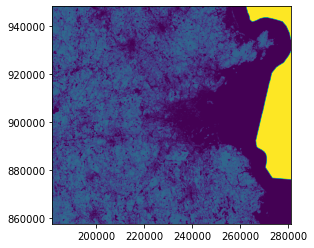

In [88]:
show(tree,transform = transform)
plt.show()

In [89]:
band1 = tree.read(1)
band = band1.astype(np.float32)/255

In [90]:
shape = tree.shape

In [91]:
MPO_Boundaries = MPO_Boundaries.to_crs('EPSG:6491')

In [92]:
zip_clipped = zip_clipped.to_crs('EPSG:6491')

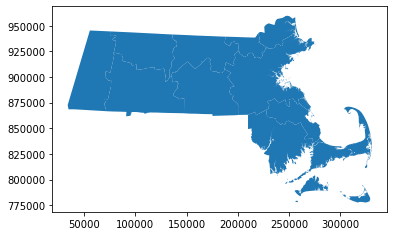

In [93]:
MPO_Boundaries.plot()
plt.show()

In [94]:
boundary_raster = features.rasterize(MPO_Boundaries['geometry'], out_shape=shape, fill=1, transform=transform, default_value=0)

In [95]:
boundary_raster

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)

In [96]:
band[boundary_raster==1]=np.nan

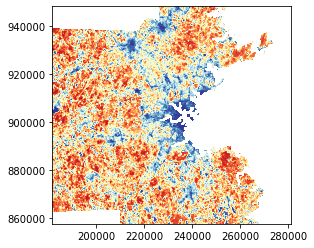

In [97]:
show(band, transform=transform, cmap='RdYlBu_r')
plt.show()

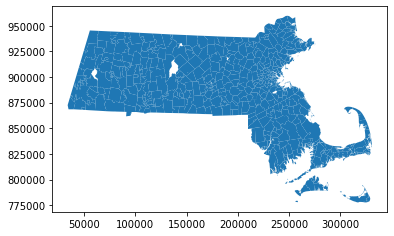

In [98]:
zip_clipped.plot()
plt.show()

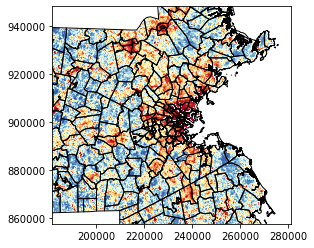

In [99]:
ax = zip_clipped.plot(facecolor='None', edgecolor='black')
show(band, cmap='RdYlBu', ax=ax, transform=transform)
plt.show()

* zonal statistics

In [100]:
stats = pd.DataFrame(zonal_stats(zip_clipped,band,affine=transform, stats=['mean'], nodata = np.NaN))

In [101]:
zip_stats = zip_clipped.join(stats)

In [102]:
ZCTA = []
for i in range(0,538):
    k = '%05d'%zip_stats['ZCTA5CE10'][i]
    ZCTA.append(k)
zip_stats['ZCTA5CE10'] = ZCTA

In [103]:
zip_stats.head()

,STATEFP10,ZCTA5CE10,GEOID10,CLASSFP10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,PARTFLG10,geometry,area,mean
0,25,02536,2502536,B5,G6350,S,71696166,9066635,+41.5969756,-070.5678768,N,"MULTIPOLYGON (((275688.314 812598.785, 275674....",7.919714e+08,NaN
1,25,02556,2502556,B5,G6350,S,10034104,1164445,+41.6394454,-070.6245149,N,"MULTIPOLYGON (((272816.173 818906.998, 272692....",1.114540e+08,NaN
2,25,02540,2502540,B5,G6350,S,27746696,4550024,+41.5741900,-070.6282848,N,"MULTIPOLYGON (((273126.263 818856.200, 273125....",3.164889e+08,NaN
3,25,02646,2502646,B5,G6350,S,7798581,801405,+41.6705961,-070.0714493,N,"MULTIPOLYGON (((318348.040 826281.410, 318355....",8.502199e+07,NaN
4,25,01237,2501237,B5,G6350,S,160121626,1140685,+42.5478177,-073.2680327,N,"POLYGON ((57310.861 917322.668, 57280.413 9173...",1.734928e+09,NaN


In [104]:
a = zip_stats.quantile([.2,.4,.6,.8],numeric_only = True)
print(a)

        ALAND10   AWATER10          area      mean
0.2   6177677.6   215541.6  6.742794e+07  0.072525
0.4  19946756.4   647198.8  2.246186e+08  0.141598
0.6  37350129.0  1462130.4  4.129910e+08  0.194079
0.8  60689658.4  2948114.4  6.724928e+08  0.222385


In [105]:
conditions = [
    (zip_stats['mean'] <= 0.072525),
    (zip_stats['mean'] > 0.072525) & (zip_stats['mean'] <= 0.141598),
    (zip_stats['mean'] > 0.141598) & (zip_stats['mean'] <= 0.194079),
    (zip_stats['mean'] > 0.194079) & (zip_stats['mean'] <= 0.222385),
    (zip_stats['mean'] > 0.222385)
    ]
values = [1,2,3,4,5]
zip_stats['score'] = np.select(conditions,values)

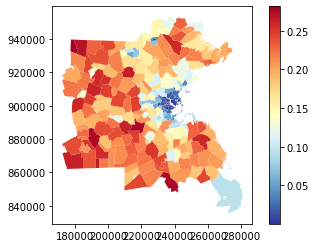

In [106]:
zip_stats.plot(column = 'mean', cmap='RdYlBu_r', legend=True)
plt.show()

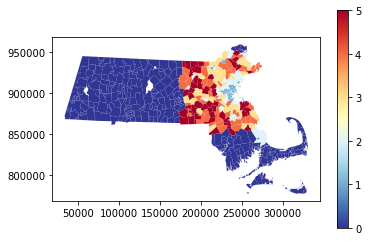

In [107]:
zip_stats.plot(column = 'score', cmap='RdYlBu_r', legend=True)
plt.show()

In [108]:
tree_highest = zip_stats[(zip_stats['score'])==5]
tree_lowest = zip_stats[(zip_stats['score'])==1]
print(tree_highest['ZCTA5CE10'])
print(tree_lowest['ZCTA5CE10'])

22     01921
58     01569
64     01568
108    01463
111    02067
128    01740
130    01529
144    02767
171    01775
173    02052
190    01532
215    01983
233    01741
239    02030
249    01516
255    01451
256    01534
257    01467
258    01525
267    02703
268    02356
276    01833
300    02493
312    02043
314    02367
337    02375
366    01474
374    01450
376    01464
377    01773
382    02054
385    02056
395    01756
403    01505
429    01944
431    01985
446    01719
452    01746
455    01770
456    01827
459    02093
461    02025
464    02061
465    02339
475    01590
479    01519
511    01469
515    01748
518    01776
523    02071
534    01503
Name: ZCTA5CE10, dtype: object
16     01841
50     02134
51     02125
52     02110
53     02118
85     01908
107    02149
117    02152
118    02109
148    01843
149    01840
150    01901
165    02144
166    02140
182    02113
184    02121
185    02119
186    02115
187    02163
244    02047
245    02135
246    02199
316    02124
318    

* unweighted score which is decided by sic factors

In [109]:
zip_clipped['weighted_score'] = (zip_age['score']+zip_community['score']+zip_hospital['score']+zip_FarmerMarket['score']+zip_FireStation['score']+zip_stats['mean'])/6

In [110]:
zip_sns = zip_clipped[['ZCTA5CE10','weighted_score','geometry']]

In [111]:
ZCTA = []
for i in range(0,538):
    k = '%05d'%zip_sns['ZCTA5CE10'][i]
    ZCTA.append(k)
zip_sns['ZCTA5CE10'] = ZCTA

C:\Users\surface\Anaconda3\envs\uep239hw7\lib\site-packages\geopandas\geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


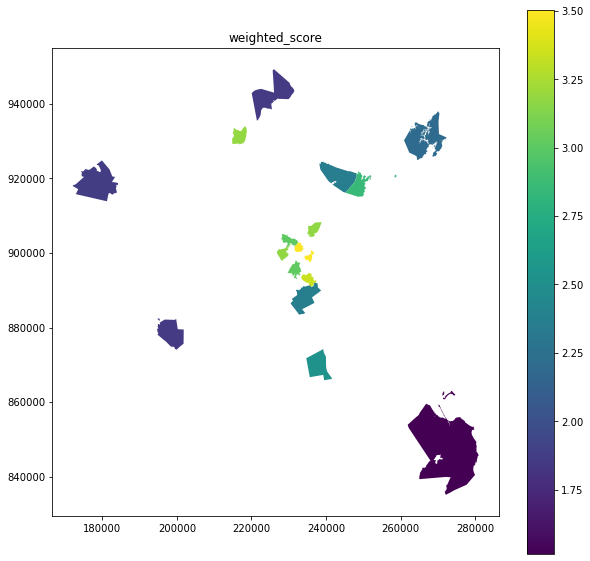

In [112]:
fig,ax = plt.subplots(1, 1, figsize=(10, 10))

zip_sns.plot(column = 'weighted_score',legend=True,ax=ax)

ax.set_title("weighted_score")

plt.show()

In [113]:
zip_sns.describe()

,weighted_score
count,18.000000
mean,2.710899
std,0.653131
min,1.515477
25%,2.238086
50%,2.931381
75%,3.177952
max,3.502345


In [114]:
highest = zip_sns[(zip_sns['weighted_score'])>2.835]
print(highest['ZCTA5CE10'])

53     02118
107    02149
183    02130
245    02135
316    02124
343    01970
361    01852
367    02138
371    02139
391    02111
Name: ZCTA5CE10, dtype: object


* zip 02139 is the best ZCTA for my father to live after his retirement in Boston